In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from random import seed, randint
import time
import pandas as pd

In [3]:
# reading dataset
(train_X, train_Y), (val_X, val_Y) = cifar10.load_data()

# shapes of data structures
print('tamaños conjunto de entrenamiento X:', train_X.shape, '  Y:', train_Y.shape)
print('tamaños conjunto de validación X:', val_X.shape, '  Y:', val_Y.shape )


170498071/170498071 [==============================] - 14s 0us/step
tamaños conjunto de entrenamiento X: (50000, 32, 32, 3)   Y: (50000, 1)
tamaños conjunto de validación X: (10000, 32, 32, 3)   Y: (10000, 1)


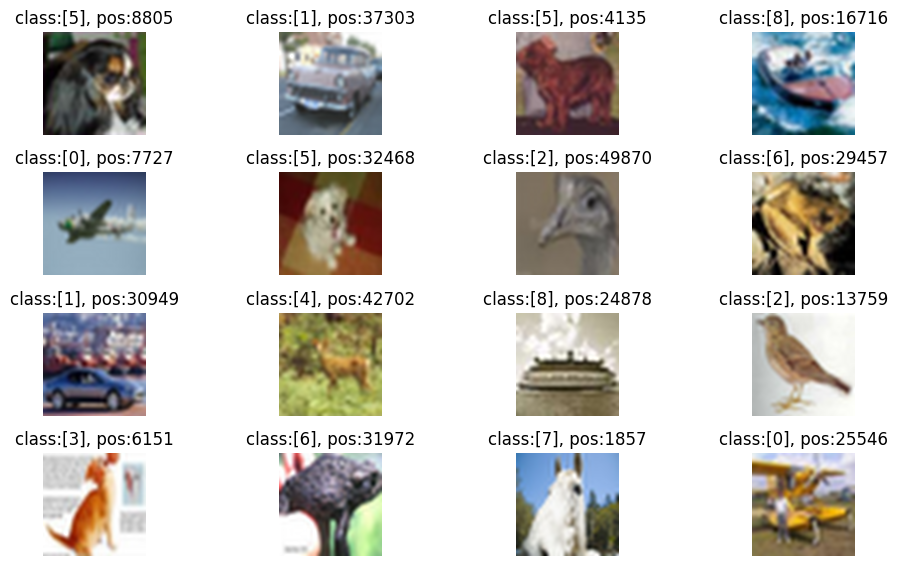

In [4]:
# displaying randomly chosen images
seed(1)
plt.figure(1, figsize=(10,6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    j = randint(0, train_Y.shape[0]-1)
    plt.imshow(train_X[j], interpolation='lanczos')
    plt.title('class:{0}, pos:{1}'.format(train_Y[j], j))
    plt.axis("off")
plt.show()

In [5]:
# preprocessing data

num_classes = 10
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

train_X /= 255
val_X /= 255

train_Y = keras.utils.to_categorical(train_Y, num_classes)
val_Y = keras.utils.to_categorical(val_Y, num_classes)

print('tamaños conjunto de entrenamiento X:', train_X.shape, '  Y:', train_Y.shape)
print('tamaños conjunto de validación X:', val_X.shape, '  Y:', val_Y.shape )

tamaños conjunto de entrenamiento X: (50000, 32, 32, 3)   Y: (50000, 10)
tamaños conjunto de validación X: (10000, 32, 32, 3)   Y: (10000, 10)


In [6]:
# model definition
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=train_X.shape[1:])) # input_shape=(32,32,3)
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

In [7]:
# hyperparameters
opt = SGD(learning_rate=0.01, momentum=0.9)
# opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

batch_size = 100
epochs = 50

best_model_path = 'best_model'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = best_model_path,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq='epoch'
)

log_path='log.csv'
history_logger = keras.callbacks.CSVLogger(
    filename=log_path,
    separator=",",
    append=True
)

# Optimización del modelo (entrenamiento)
start_time = time.time()
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y), shuffle=True, callbacks=[model_checkpoint, history_logger])
print('Tiempo: {0:.2f} min'.format((time.time()-start_time)/60))


Epoch 1/50
500/500 [==============================] - 97s 193ms/step - loss: 2.0787 - accuracy: 0.2273 - val_loss: 1.8600 - val_accuracy: 0.3394
Epoch 2/50
363/500 [====================>.........] - ETA: 28s - loss: 1.6775 - accuracy: 0.3931

KeyboardInterrupt: 

In [ ]:
# recovering the best model
model.load_weights(best_model_path)

In [ ]:
# testing de model
train_res = model.evaluate(train_X, train_Y, verbose=0)
val_res = model.evaluate(val_X, val_Y, verbose=0)

print('Resultados ENTRENAMIENTO: loss={:.4f}, accuracy={:.4f}'.format(train_res[0], train_res[1]))
print('Resultados VALIDACIÓN: loss={:.4f}, accuracy={:.4f}'.format(val_res[0], val_res[1]))

# plotting learnin curves
plt.figure(2)
plt.plot(range(1,epochs+1), history.history['accuracy'])
plt.plot(range(1,epochs+1), history.history['val_accuracy'])
plt.xticks(range(1,epochs+1))
plt.xlim(1,epochs)
plt.ylim(0, 1)
plt.show()